preprocess.py (전체 흐름)

load & reorient & HU

resample 3D

skull strip & optional center crop

window & normalize (loop over experiments)

pad_or_crop_safe to shape.volume

for each axis, method → generate projection, apply same window/normalize, pad2d to shape.slice

torch.save with keys

In [ ]:
# 로컬: %cd C:\Users\401-09\Preprocessing

In [ ]:
# 필요시 폴더 삭제
!rm -r 경로명

In [ ]:
%cd /content

/content


In [1]:
# GitHub에서 프로젝트 클론
#    → <YOUR_REPO_URL> 부분을 실제 리포지토리 URL로 바꿔주세요.
!git clone https://github.com/MANDUnoko/Preprocessing
%cd Preprocessing

Cloning into 'Preprocessing'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 335 (delta 30), reused 48 (delta 16), pack-reused 257 (from 2)
Receiving objects: 100% (335/335), 572.27 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/Preprocessing


In [54]:
!git fetch origin main

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 362 bytes | 362.00 KiB/s, done.
From https://github.com/MANDUnoko/Preprocessing
 * branch            main       -> FETCH_HEAD
   b3087cc..33680b6  main       -> origin/main


In [55]:
!git checkout origin/main -- /content/Preprocessing/scripts/preprocess.py

In [56]:
!git checkout origin/main -- /content/Preprocessing/configs/preprocessing.yaml

In [ ]:
# Google Drive 마운트 (필요한 경우)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
!sed -n '1,20p' configs/preprocessing.yaml

# 기본 데이터 경로
data_dir: "data"

# 파일 확장자
extensions:
  raw:         ".nii.gz"
  brain_mask:  ".nii.gz"
  lesion:      ".nii"

# Voxel spacing (z, y, x) — 원본 스캔 vs 목표 isotropic
spacings:
  original: [5.0, 0.4121, 0.4121]  # 원본 CT의 Z/Y/X 해상도 [mm]
  target:   [1.0, 1.0, 1.0]        # 모두 1mm로 맞춰 재샘플링

# 실험할 Window 범위 목록 (clip_min, clip_max)
window:
  experiments:
    - [0,    80]   # 기본 soft-tissue 강조 (WL=40, WW=80)
    - [0,   200]   # bone 포함
    - [-50, 250]   # subarachnoid 대비



>>> Processing case 049
원본 HU 범위: -1024.0 2914.0
Resampled 후 HU 범위: -1020.01984 2816.7812
Skullstrip 후 HU 범위: -988.2504 1759.9825
Mask sum: 1575390.0 Brain mask sum: 1926994.0
volume_channels[0] mean/std: 0.417701 0.458614
volume_channels[1] mean/std: 0.379776 0.455678
volume_channels[2] mean/std: 0.469443 0.388405
volume_channels[3] mean/std: 0.476725 0.377430
[✔] Preprocessed and saved: 049.pt


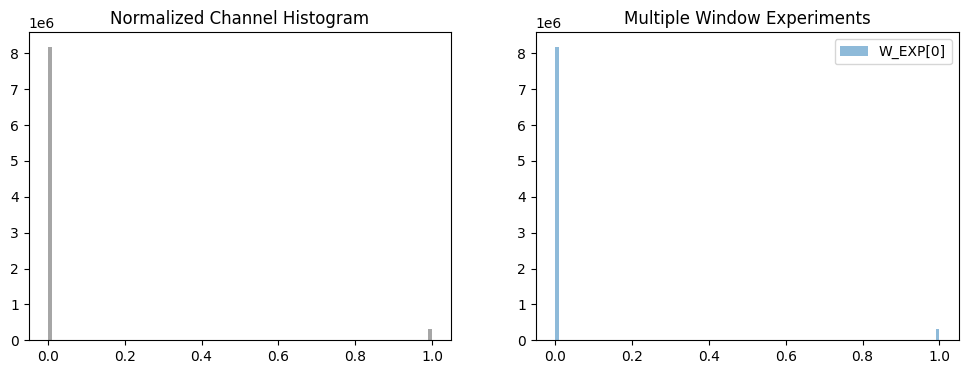

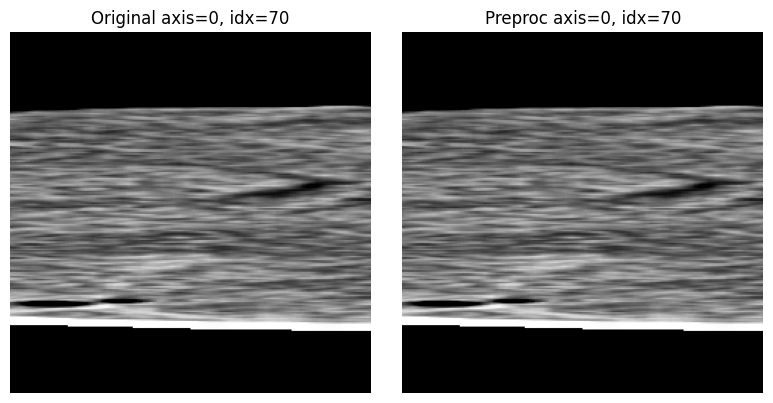

<Figure size 640x480 with 0 Axes>

In [58]:
%run scripts/preprocess.py \
  --data_dir "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data" \
  --cases 049

In [ ]:
# 폴더 전체 처리

In [59]:
from pathlib import Path
import torch
import numpy as np

# ===== 사용자 설정 =====
case_id = "049"
processed_dir = Path("/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/processed")
pt_path = processed_dir / f"{case_id}.pt"

# ===== .pt 로드 및 분해 =====
data = torch.load(pt_path)
image = data["volume"][0].numpy()     # shape: (D, H, W)
mask  = data["mask"][0].numpy()

# ===== 기본 통계 =====
print(f"[Image Stats: case {case_id}]")
print(f"  Mean:     {image.mean():.4f}")
print(f"  Std:      {image.std():.4f}")
print(f"  Min/Max:  {image.min():.2f} / {image.max():.2f}")
print(f"  Shape:    {image.shape}")
print(f"  Spacing:  {data['meta']['spacing']}")

# ===== Signal Quality (SNR / CNR) =====
lesion     = image[mask == 1]
background = image[(mask == 0) & (image > 0)]

if lesion.size > 0 and background.size > 0:
    snr = lesion.mean() / (lesion.std() + 1e-5)
    cnr = abs(lesion.mean() - background.mean()) / (background.std() + 1e-5)
    status = "Good" if snr > 1.0 and cnr > 0.5 else "Poor"

    print("\n[Signal Quality]")
    print(f"  Lesion voxels:     {lesion.size}")
    print(f"  Background voxels: {background.size}")
    print(f"  SNR:  {snr:.4f}  (기준 > 1.0)")
    print(f"  CNR:  {cnr:.4f}  (기준 > 0.5)")
    print(f"  상태 판단: {status}")
else:
    print("\n[Signal Quality] 병변 또는 배경 데이터가 충분치 않음")

[Image Stats: case 049]
  Mean:     0.0503
  Std:      0.2024
  Min/Max:  0.00 / 1.00
  Shape:    (140, 250, 250)
  Spacing:  (1.0, 1.0, 1.0)

[Signal Quality]
  Lesion voxels:     90
  Background voxels: 574376
  SNR:  3.9188  (기준 > 1.0)
  CNR:  0.9368  (기준 > 0.5)
  상태 판단: Good


In [42]:
import torch
import nibabel as nib
import numpy as np
from pathlib import Path

# 1. .pt 파일 로드
case_id = "049"
pt_path = Path("/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/processed") / f"{case_id}.pt"
data    = torch.load(pt_path)

vol   = data["volume"].numpy()    # shape = (C, D, H, W)
mask  = data["mask"].numpy()      # shape = (1, D, H, W) or (D, H, W)

# 2. 채널 중 하나 골라서 (D, H, W) 배열 획득
vol0 = vol[0]                     # (D, H, W)
mask = np.squeeze(mask)           # (D, H, W)

# 3. 화면용으로 transpose: (D, H, W) → (H, W, D)
vol_view  = np.transpose(vol0, (1, 2, 0))   # (H, W, D)
mask_view = np.transpose(mask, (1, 2, 0))   # (H, W, D)

# 4. affine 설정: 여기선 단위행렬 사용
affine = np.eye(4)

# 5. NIfTI 생성 & 저장
out_dir = Path("/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data")
out_dir.mkdir(parents=True, exist_ok=True)

nib.save(nib.Nifti1Image(vol_view.astype(np.float32), affine),
         out_dir / f"{case_id}_vol_view.nii.gz")
nib.save(nib.Nifti1Image(mask_view.astype(np.uint8), affine),
         out_dir / f"{case_id}_mask_view.nii.gz")

print(f"[✔] View용 NIfTI 저장 완료: {case_id}")

[✔] View용 NIfTI 저장 완료: 049
